# Housing
**Tivoli Model One** has a nice housing, unfortunately even broken models still cost a lot of money (€65/pce).  There are cheaper, lower quality clones available :
* Nedis König HAV-TR13
* ...

# Architecture
* Front panel : replaces original front panel
  * PCB
    * 2 layer PCB
    * 1.2mm thickness
    * size : 111 x 208 mm
    * JLCPCB : €12 for 5 pcs
    * Black soldermask, white silkscreen
  * 2 rotary encoders with push button
    * attached with its bushing and M7 nut to the front panel
    * connect to back side of front panel PCB with 2.54mm pin headers (SMD)
  * 1 momentary switch
    * no electrical connection to front panel
    * hole in front panel between the two rotary encoders
  * PIR-sensor
    * mounted on the front, above the momentary switch
    * no electrical connection to front panel
  * O-LED display
    * no electrical connection to front panel
    * bezel fixed to front panel (requires 1.2mm thick PCB)
    * cutout in front panel to allow for FFC to be connected on the back side of the front panel.
    * If flush-mount of the display is required, then an extra panel is needed and a cutout in the front panel to make room for the bezel.  Apart from aesthetics, it doesn't have any benefits, so it won't be done here.
  * loudspeaker
    * mounted on the front, left side
    * reusing parts salvaged from original housing.
* Main board :
  * 4 layer PCB
  * mounted behind front panel
  * connects to the rotary encoders
  * contains momentary switch
  * has FFC-connector and additional circuitry for O-LED display
  * has connector for power.

# Microcontroller
## Options
Dual core needed for web radio and user interface.  That rules out ESP32-C3.

### ESP32
* For programming, a UART is needed, which requires either opening the housing to connect a programmer, or add the programmer to the PCB.
* Works with Husarnet.

### ESP32-S3
* No Husarnet support yet (as of 2023-12-30).
* Can be programmed and debugged via USB-C connector.

# Presence sensor
## Choice
* [BS412](https://cdn-shop.adafruit.com/product-files/4666/Datasheet.pdf)
* [Adafruit 4666](https://www.digikey.be/en/products/detail/adafruit-industries-llc/4666/13175534)

## Parameters
* BL412 as second sensor
* 10µA current consumption, so very low power
* 3.3V supply voltage

# Display
## Options
### LCD/TFT
* Cheaper
* RGB
* integrated touch

### OLED
* single color, choose white to match the silk screen
* Doesn't need a backlight, so should have more contrast than LCD.  When it's dark, the dark pixels are off, no backlight to shine through.
* [2.42" OLED Display 128x64 pixels - White, SKU: 004993](https://www.tinytronics.nl/shop/en/displays/oled/2.42-inch-oled-display-128*64-pixels-white-i2c)
* [Adafruit Monochrome 2.42" 128x64 OLED Graphic Display Module Kit Product ID: 2719 ](https://www.adafruit.com/product/2719)
* [Waveshare 25742](https://www.waveshare.com/2.42inch-oled-module.htm?sku=25742)
* [Focus O12864B-GW-TW3](https://www.digikey.be/en/products/detail/focus-lcds/O12864B-GW-TW3/12691219)
* [Adafruit usage info](https://learn.adafruit.com/1-5-and-2-4-monochrome-128x64-oled-display-module?view=all)

# Power source
## Options
### ~~DC Barrel Jack~~
* cheap (connectors, cables, adapters)
* not much hardware needed
* no control over input voltage 

### USB-C
* more expensive (connectors, cables, adapters)
* uses standard USB-C cables and phone chargers

# Internal connections
Using SATA data cable and connectors : cheap, easy to connect, cable assembly length is ok.
100ohm differential impedance is not perfect for USB, but should be ok for short distances.

# Rotary encoder
* For development/debug : breakout board from tinytronics.
* For final design: Bourns PEC11R-4220F-S0024

# Development kit
## Options
### AI-Thinker ESP32 Audio Kit
* ESP32-A1S module has internal I2C, unfortunately it's connected to external pins on the development board.
* Very limited pinout
* There's an ES8388 audio codec on the board.  It's connected to the ESP32 via I2S.  
* The ES8388 is controlled via I2C, which is inaccessible from outside of the module.  There's noticeable noise on both the headphone output and the power amplifier.  There's also sometimes creaking sound, which disappears often when restarting the stream.

### ESP32-LyraT-Mini
* [website](https://docs.espressif.com/projects/esp-adf/en/latest/design-guide/dev-boards/get-started-esp32-lyrat-mini.html)
* Uses ES8311 audio codec ($0.44)

# Audio output
The ideal part would be an "I²S-AMP" : I²S input-DAC and a built-in PA.  e.g. MAX98357A, available on a [module](https://www.tinytronics.nl/shop/nl/audio/versterkers/dfrobot-max98357-i2s-versterker-module-2.5w).

## Class-D filter
* [SLAA701A : LC Filter Design](https://www.ti.com/lit/an/slaa701a/slaa701a.pdf)
* [Class D Audio Amplifier Output Filter Optimization](https://www.analog.com/en/technical-articles/class-d-audio-amplifier-output-filter-optimization.html)

In [2]:
import math 

Rbtl = 8 # [ohm] speaker impedance
fc = 40e3 # [Hz] cutoff frequency

# Single ended LC-filter, critical damping
ω0 = 2*math.pi*fc

# Hybrid Filter Frequency Response, according to SLAA701A
Rl = Rbtl/2
L = Rl * 2**0.5 / ω0  # [H] inductor value

# Replace calculated inductor value with standard value
Lbtl = L = 22e-6 # [H] inductor value

C = 1/(ω0 * Rl * 2**0.5) # [F] capacitor value
Cbtl = C / 2.2
Cg = Cbtl * 0.2

# Replace calculated capacitor value with standard value
Cbtl = 330e-9
Cg = 68e-9

# Calculate damping factor
Q = Rbtl/2 * math.sqrt(2.2*Cbtl/Lbtl)

# Calculate the cutoff frequency
f0 = 1/(2*math.pi * math.sqrt(Lbtl * 2.2 * Cbtl))


# Speaker

In order to simulate the filter correctly, we have to know its load.
The frequency response of an 8 ohm / 3W speaker has been measured with a NanoVNA.

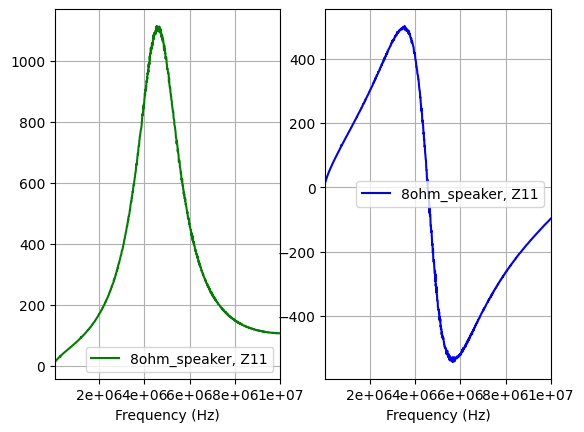

In [3]:
import skrf as rf # scikit-rf
import matplotlib.pyplot as plt
filepath = './hardware/8ohm_speaker.s1p'
nw = rf.Network(filepath)
fig, (ax1, ax2) = plt.subplots(1,2)
nw.plot_z_re(m=0, n=0, ax=ax1, color='g')
nw.plot_z_im(m=0, n=0, ax=ax2, color='b')
ax1.grid()
ax2.grid()

The hybrid filter works well with a real 8ohm load, but with a speaker load, there's 6dB peak at 48kHz.  For both loads, there's no difference between the hybrid filter and the LC filter above 250kHz.
The switching frequency of the amplifier is 300kHz, which is attenuated by 34dB.

For the final implementation, a resistor will be added in series with the capacitor to dampen the resonance.  To overcome the zero in the filter, introduced by the resistor, a second capacitor will be added in parallel with the resistor.  So past the zero, the filter will roll-off at 40dB/decade.



# Firmware
## Toolchain
### Options
#### ESP-IDF

#### PlatformIO with Arduino

### Choice
PlatformIO with Arduino : I've made a working web radio with this toolchain, so I'm familiar with it.

## Web radio
* [ESP32-audiokit-webradio-webinterface](https://github.com/thieu-b55/ESP32-audiokit-webradio-webinterface/tree/main) : badly written code, but leads me on the path to an ES8388 driver.
* [ESP32-MiniWebRadio](https://github.com/schreibfaul1/ESP32-MiniWebRadio)
* [ESP32_WebRadio ](https://github.com/michelep/ESP32_WebRadio) : streams saved as a json file. All code in a single .ino file.

### Libraries

#### Remote monitoring
[Husarnet](https://husarnet.com/) : remote access to ESP32.  It's free for non-commercial use (up to 5 devices).  This is optional, but it's nice to be able to monitor the device remotely.

Several APIs are available :
* [SimpleCLI](https://github.com/SpacehuhnTech/SimpleCLI) with Husarnet-server: send custom commands over TCP-socket to ESP32.  We might send JSON or XML over the socket to control the device.
* Websockets : bi-directional, full-duplex communication over a persistent TCP connection, stateful
  * [ESP8266WebCLI](https://github.com/SpacehuhnTech/SimpleCLI/blob/master/examples/ESP8266WebCLI/ESP8266WebCLI.ino) : simple web interface to send commands to ESP32
* [Telnet](https://github.com/LennartHennigs/ESPTelnet) : You can send and receive strings over the telnet connection.  We might send JSON or XML over the socket to control the device.
* RESTful HTTP : HTTP is a request-response based protocol, stateless, using non-persistent TCP connections
```json
curl --header "Content-Type: application/json" \
  --request POST \
  --data '{"username":"xyz","password":"xyz"}' \
  http://localhost:3000/api/login
```

#### Stream decoding
* [ESP32-audioI2S](https://github.com/schreibfaul1/ESP32-audioI2S) : I2S audio library for the ESP32
  * no need to pass in media type
  * shows song title
  * allows to quickly switch between streams
* ~~[arduino-audiokit](https://github.com/pschatzmann/arduino-audiokit)~~ : crashes or produces junk audio when switching between MP3 and AAC streams

#### O-LED
* [Adafruit_SSD1305](https://github.com/adafruit/Adafruit_SSD1305) : works
* ~~[SSD1306Ascii](https://github.com/greiman/SSD1306Ascii/)~~ : used by ArduinoMenu-library, only text support (probably subset from Adafruit library), works

#### Audio codec ES8388
Mix of following libraries :
* [es8388arduino](https://github.com/vanbwodonk/es8388arduino)
* [es8388](https://github.com/maditnerd/es8388)
* [arduino-audiokit](https://github.com/pschatzmann/arduino-audiokit)

#### Knob / Rotary encoder
* paulstoffregen/Encoder @ ^1.4.2 : works with Husarnet version of espressif32 platform.  Crashes with official version of espressif32 platform.
  alternative rotary encoder library : mathertel/RotaryEncoder (used on https://github.com/LieBtrau/better-alarm-clock/blob/master/firmware/full-application/lib/TactileElements/RotaryEncoder_Tactiles.cpp)

#### Buttons
  thomasfredericks/Bounce2 @ ^2.71

#### Menu library
There are many libraries for LCD displays, but not many for OLED displays.  The following libraries support OLED displays :
* [arduino-menusystem](https://github.com/jonblack/arduino-menusystem):
  * Builds a menu tree from a list of menu items and a way to navigate the menu items.
  * No IO-support, so no support for rotary encoder or OLED.
* ~~[LCDMenuLib2](https://github.com/Jomelo/LCDMenuLib2)~~:
  * a lot of work to get the Arduino code to compile on PlatformIO
  * a lot of files.  Looks complex.
  * Menu items are not displayed correctly.
* ~~[ArduinoMenu](https://github.com/neu-rah/ArduinoMenu)~~
  * supports rotary encoder and OLED
  * unintuitive navigation for item lists that are longer than the screen can show.
* ~~[TcMenu](https://www.thecoderscorner.com/products/arduino-libraries/tc-menu/tcmenu-plugins/adafruit_gfx-renderer-plugin/)~~ : looks complex

#### Other
  stevemarple/AsyncDelay @ ^1.1.2

# Radio stations
When no file format is given, execute a ```wget``` with the url to get the content type.

## Belgium
* [JoeFM](http://icecast-qmusicbe-cdp.triple-it.nl/joe.mp3)
* [QMusic](http://icecast-qmusicbe-cdp.triple-it.nl/qmusic.mp3)
* [Radio Nostalgie](http://25633.live.streamtheworld.com/NOSTALGIEWHATAFEELING.mp3)
* [MNM](http://vrt.streamabc.net/vrt-mnm-mp3-64-4492886) : audio/mpeg
* [VRT NWS](http://progressive-audio.vrtcdn.be/content/fixed/11_11niws-snip_lo.mp3)

## Philippines
* [Bespren Radio](http://streamnavs.net:8089/live) : audio/aacp
* [Tunog Pinoy Power FM](http://streamnavs.net:8143/live) : audio/aacp
* [Win Radio 107.9 Naga](http://streamnavs.net:8161/stream) : audio/aacp
* [94.7 Happy Radio](http://stream-152.zeno.fm/2xk9xz3wpl2vv?zs=Pb9DJKxNRxmKiS4Pa6O9SQ) : audio/mpeg
* [DWAY Care 104.3](http://sg-icecast.eradioportal.com:8000/febc_dway) : audio/mpeg
* [Love Radio](http://loveradiolegaspi.radioca.st/;) : audio/mpeg
* [Barangay LS97.1](https://magic.radioca.st/stream) : audio/mpeg
* [Hugot Radio 2.0](http://cast3.asurahosting.com/proxy/istreamo/stream) : audio/mpeg
* [OK FM Legazpi](http://server10.reliastream.com:8063/xstream)